# 0.0 Imports

## 0.1. Libries

In [1]:
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import nltk
import unidecode

from string                          import punctuation 

from nltk.corpus                     import stopwords
from nltk                            import tokenize

from sklearn.model_selection         import train_test_split
from sklearn.linear_model            import LogisticRegression as lr
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
from wordcloud                       import WordCloud

## 0.2. Load Data

In [2]:
df_raw = pd.read_csv('data/imdb-reviews-pt-br.csv')

## 0.3 Helper Functions

In [3]:
def classificar_texto(df, coluna_texto, target, n_features):

    #Modelo do tipo bag_of_words usando CountVectorizer
    vetorizar = CountVectorizer(lowercase=False, max_features = n_features)#max_features delimite o tamanho do vetor usado
    bag_of_words = vetorizar.fit_transform(df[coluna_texto])

    #separa treino e teste
    treino, teste, classse_treino, classe_teste = train_test_split(bag_of_words,
                                                                  df[target], 
                                                                  random_state = 42)
    #treinar modelo
    regressao_logistica = lr(solver = 'lbfgs')
    regressao_logistica.fit(treino, classse_treino)
    return regressao_logistica.score( teste, classe_teste )

def nuvem_palavras(df, coluna_texto ):
    #lista com todas as palavras do campo text_pt
    todas_palavras = ' '.join([texto for texto in df[coluna_texto]])

    #WordCloud
    nuvem_palavras = WordCloud( width = 800, height = 500,
                                max_font_size = 110,
                              collocations = False ).generate(todas_palavras)
    
    #plotando grafico de palavras
    plt.figure(figsize=(20,18));
    plt.imshow(nuvem_palavras, interpolation = 'bilinear');
    plt.axis('off')
    plt.show();
    
def pareto(df, coluna_texto, quantidade):
    todas_palavras = ' '.join([resenha for resenha in df[coluna_texto]])
    token_espaco = nltk.tokenize.WhitespaceTokenizer()
    token_frase = token_espaco.tokenize(todas_palavras)
    frequencias = nltk.FreqDist(token_frase)
    df_frequencias = pd.DataFrame({'Palavras': list(frequencias.keys()),
                               'Frequencia': list(frequencias.values())})
    df_frequencias = df_frequencias.nlargest(n=quantidade, columns='Frequencia')

    total = df_frequencias['Frequencia'].sum()
    df_frequencias['Porcentagem'] = df_frequencias['Frequencia'].cumsum() / total * 100

    plt.figure(figsize=(12,8))
    ax = sns.barplot(data=df_frequencias, x='Palavras', y='Frequencia', color='gray')
    ax2 = ax.twinx()
    sns.lineplot(data=df_frequencias, x='Palavras', y='Porcentagem', color='red', sort=False, ax=ax2)
    plt.show()  

# 1.0. Data Description

In [4]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [5]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of Rows: 49459
Number of cols: 4


## 1.2. Data Types

In [6]:
df1.dtypes

id            int64
text_en      object
text_pt      object
sentiment    object
dtype: object

## 1.3. Check NA

In [7]:
df1.isna().sum()

id           0
text_en      0
text_pt      0
sentiment    0
dtype: int64

# 2.0 Feature Engineering

In [8]:
df2 = df1.copy()

In [9]:
#coluna classificação, transformar valores de sentiment para binario
classificacao = df2['sentiment'].replace(['neg', 'pos'], [0,1])
df2['classificacao'] = classificacao

## Tratando os Dados

### Tratamento 1 - StopWords 

> Na biblioteca NLTK, temos uma função que indica as palavras de palavras irrelevatntes, chaamdo de stopwords

In [10]:
#Gerando coluna tratamento_1 sem palavras irrelevantes segundo stopwords do NLTK
#nltk.download('stopwords')
palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")
token_espaco = nltk.tokenize.WhitespaceTokenizer()
frase_processada = list()
for opiniao in df2.text_pt:
    nova_frase = list()
    palavras_texto = token_espaco.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in palavras_irrelevantes:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))

df2["tratamento_1"] = frase_processada
df2.head(3)

id                                            text_en  \
0   1  Once again Mr. Costner has dragged out a movie...   
1   2  This is an example of why the majority of acti...   
2   3  First of all I hate those moronic rappers, who...   

                                             text_pt sentiment  classificacao  \
0  Mais uma vez, o Sr. Costner arrumou um filme p...       neg              0   
1  Este é um exemplo do motivo pelo qual a maiori...       neg              0   
2  Primeiro de tudo eu odeio esses raps imbecis, ...       neg              0   

                                        tratamento_1  
0  Mais vez, Sr. Costner arrumou filme tempo nece...  
1  Este exemplo motivo maioria filmes ação mesmos...  
2  Primeiro tudo odeio raps imbecis, poderiam agi...

### Tratamento 2 - Potuação e acentos using NLTK

In [11]:
#Criando lista de pontuação usando punctuation
pontuacao = list()
for ponto in punctuation:
    pontuacao.append(ponto)

#Adicionando pontuação na lista de stop words
stopwords = pontuacao + palavras_irrelevantes
stopwords = [unidecode.unidecode(texto) for texto in stopwords]
frase_processada = list()
token_pontuacao = tokenize.WordPunctTokenizer()
for opiniao in df2["tratamento_1"]:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in stopwords:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))

df2["tratamento_2"] = frase_processada

df2["tratamento_2"] = frase_processada
df2.head(3)

id                                            text_en  \
0   1  Once again Mr. Costner has dragged out a movie...   
1   2  This is an example of why the majority of acti...   
2   3  First of all I hate those moronic rappers, who...   

                                             text_pt sentiment  classificacao  \
0  Mais uma vez, o Sr. Costner arrumou um filme p...       neg              0   
1  Este é um exemplo do motivo pelo qual a maiori...       neg              0   
2  Primeiro de tudo eu odeio esses raps imbecis, ...       neg              0   

                                        tratamento_1  \
0  Mais vez, Sr. Costner arrumou filme tempo nece...   
1  Este exemplo motivo maioria filmes ação mesmos...   
2  Primeiro tudo odeio raps imbecis, poderiam agi...   

                                        tratamento_2  
0  Mais vez Sr Costner arrumou filme tempo necess...  
1  Este exemplo motivo maioria filmes ação mesmos...  
2  Primeiro tudo odeio raps imbecis poderiam agir...

### Tratamento 3 -Retirando acentos usando unicode

In [12]:
#Retirando os acentos
sem_acentos = [unidecode.unidecode(texto) for texto in df2["tratamento_2"]]
df2['tratamento_3'] = sem_acentos

#criando lista de palavras stopwords sem acento
stopwords_sem_acento = [unidecode.unidecode(texto) for texto in stopwords]

#Fazendo a interação para criar lista 3 com stops words sem acentos
frase_processada = list()
for opiniao in df2["tratamento_3"]:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in stopwords_sem_acento:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))

df2["tratamento_3"] = frase_processada
df2.head()

id                                            text_en  \
0   1  Once again Mr. Costner has dragged out a movie...   
1   2  This is an example of why the majority of acti...   
2   3  First of all I hate those moronic rappers, who...   
3   4  Not even the Beatles could write songs everyon...   
4   5  Brass pictures movies is not a fitting word fo...   

                                             text_pt sentiment  classificacao  \
0  Mais uma vez, o Sr. Costner arrumou um filme p...       neg              0   
1  Este é um exemplo do motivo pelo qual a maiori...       neg              0   
2  Primeiro de tudo eu odeio esses raps imbecis, ...       neg              0   
3  Nem mesmo os Beatles puderam escrever músicas ...       neg              0   
4  Filmes de fotos de latão não é uma palavra apr...       neg              0   

                                        tratamento_1  \
0  Mais vez, Sr. Costner arrumou filme tempo nece...   
1  Este exemplo motivo maioria filmes ação mesmos...   
2  Primeiro tudo odeio raps imbecis, poderiam agi...   
3  Nem Beatles puderam escrever músicas todos gos...   
4  Filmes fotos latão palavra apropriada eles, ve...   

                                        tratamento_2  \
0  Mais vez Sr Costner arrumou filme tempo necess...   
1  Este exemplo motivo maioria filmes ação mesmos...   
2  Primeiro tudo odeio raps imbecis poderiam agir...   
3  Nem Beatles puderam escrever músicas todos gos...   
4  Filmes fotos latão palavra apropriada verdade ...   

                                        tratamento_3  
0  Mais vez Sr Costner arrumou filme tempo necess...  
1  Este exemplo motivo maioria filmes acao mesmos...  
2  Primeiro tudo odeio raps imbecis poderiam agir...  
3  Nem Beatles puderam escrever musicas todos gos...  
4  Filmes fotos latao palavra apropriada verdade ...

# 3.0. EAD

In [13]:
df3 = df2.copy()

## 3.1. Analisando text_pt

> Aqui vamos dar uma olhada em uma resenha que seja positiva e uma negativa, para ver os tipos de palavras usadas e pensar como o algortmo poderia reconhecer uma resenha como positiva ou negativa. 

In [14]:
#exemplo de resenha negativa
print('Negativa \n')
print(df3.text_pt[189])

Negativa 

Este é sem dúvida o pior filme que eu já vi. E acredite em mim, eu vi muitos filmes. A reviravolta inacreditável que o filme faz - passando de um extremamente mau filme "Formas de vida alienígenas habitam a terra", com um filme que tenta espalhar um arquicristiano "O dia do julgamento está próximo, buscar Jesus ou queimar por toda a eternidade em as dívidas ardentes do inferno "mensagem - deixou-me atordoado depois de ter sido atormentado por 85 minutos. Até mesmo os cristãos religiosos devem se envergonhar ou ficar furiosos ao ver suas crenças postadas dessa maneira. Eu não sabia o que fazer comigo quando assisti a atuação horrível que poderia ter sido realizada por crianças de 7 anos de idade. Simplesmente repugnante. Eu não sou cristão nem muito religioso. Mas se eu estivesse, não teria mais medo do Inferno. Rich Christiano mostrou ser algo muito pior.


In [15]:
#exemplo de resenha positiva
print('Positiva \n')
print(df3.text_pt[49002])

Positiva 

Crescendo em Nova York no final dos anos 80 e início dos anos 90, posso dizer pessoalmente que este é um dos documentários mais importantes feitos para cobrir esse lugar neste período de tempo. Não Madonna não veio com a idéia de Voguing, mas é de onde ela tirou! Em vez de combater a violência uns dos outros ou em brigas de gato, o voguing permitia que as pessoas "lutassem" dentro dos confins de tudo, menos que tocassem umas às outras, o que justificaria uma desqualificação automática. Vendo este tipo de extraordinariamente talentosas / bem orquestradas "jogadas" nos clubes foi nada menos do que espetacular e todos os grandes nomes de antigamente estão aqui ... Pepper La Beija, Paris Duprée, Xtragavaganza, etc. ..tudo comemorado nos gostos de peças de época como a música de Malcom McLarens "Deep in Vogue" ... não importava quem você era, ou de onde você era porque quando você passava por aquelas portas nesse "reino mágico" de De certa forma, você se tornou parte de algo maio

## 3.2. Analisando variável alvo, classificacao

In [16]:
#Analisando o balanceamento
print(round(df3.classificacao.value_counts(normalize=True)*100, 2) )

0    50.07
1    49.93
Name: classificacao, dtype: float64


> Temos a variável alvo bem balanceada, com praticamente metade indicando respostas positivas e metade respostas negativas. 

## 3.3 WordCloud

### Todas as palavras

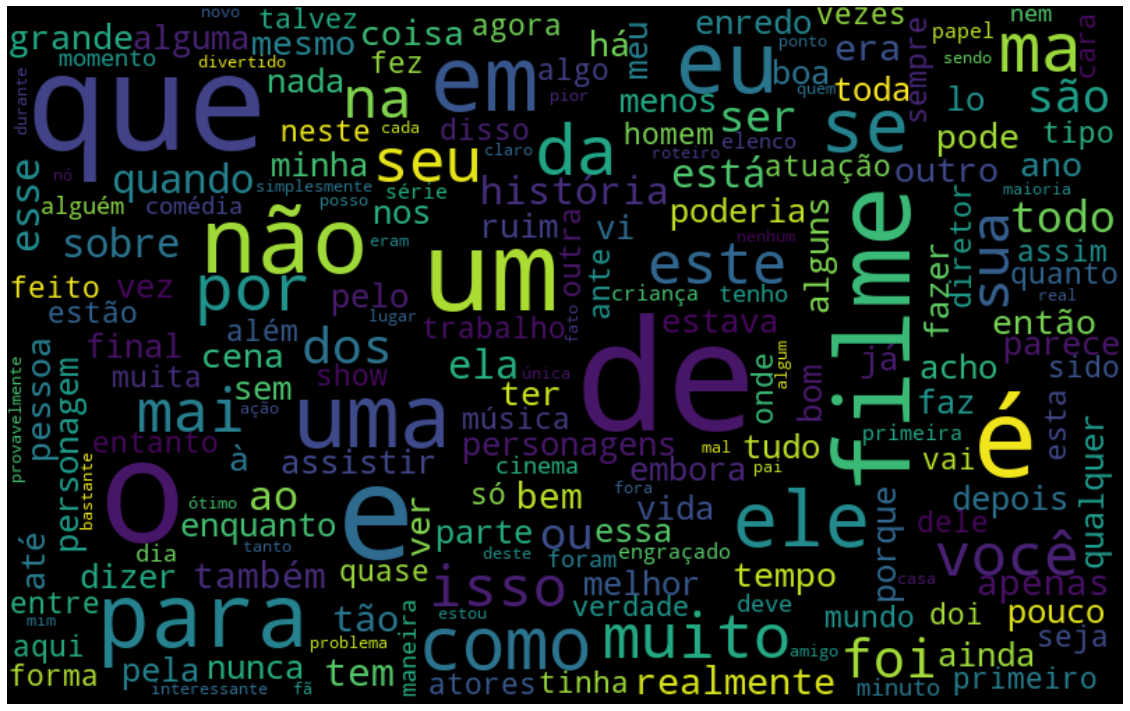

In [17]:
#Todas as palavras na wordcloud
nuvem_palavras(df3, 'text_pt')

### Todas as palavras - Pós tratamento 1

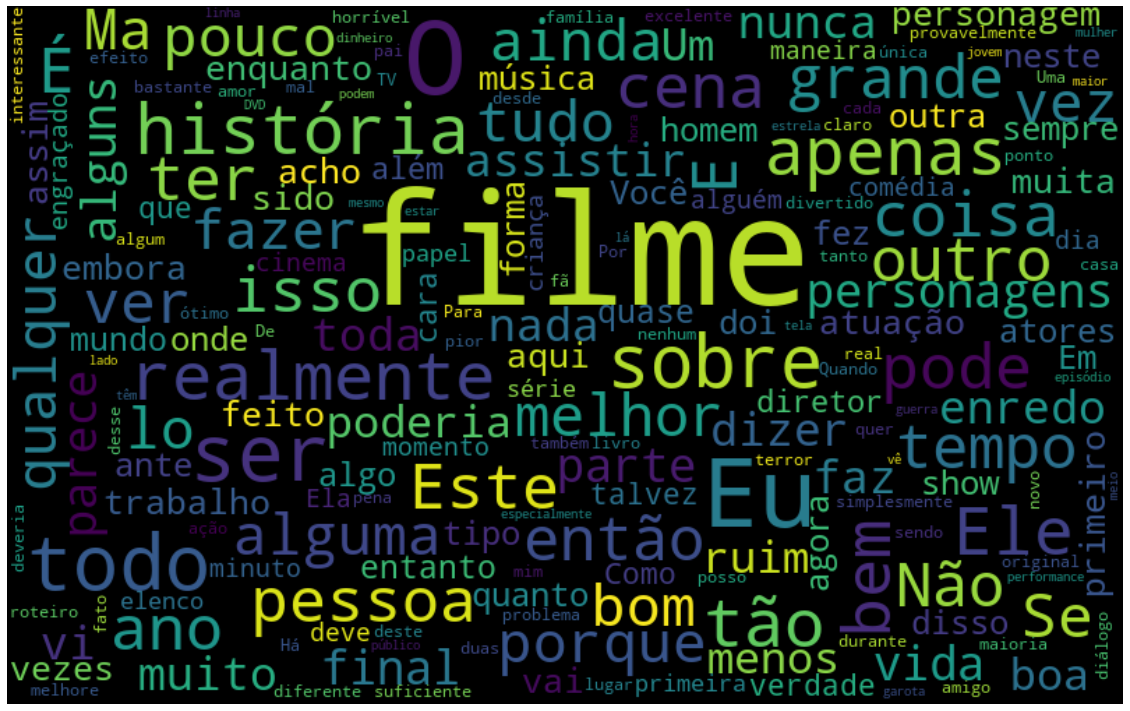

In [18]:
nuvem_palavras(df3, 'tratamento_1')

### Todas as palavras - Pós tratamento 2

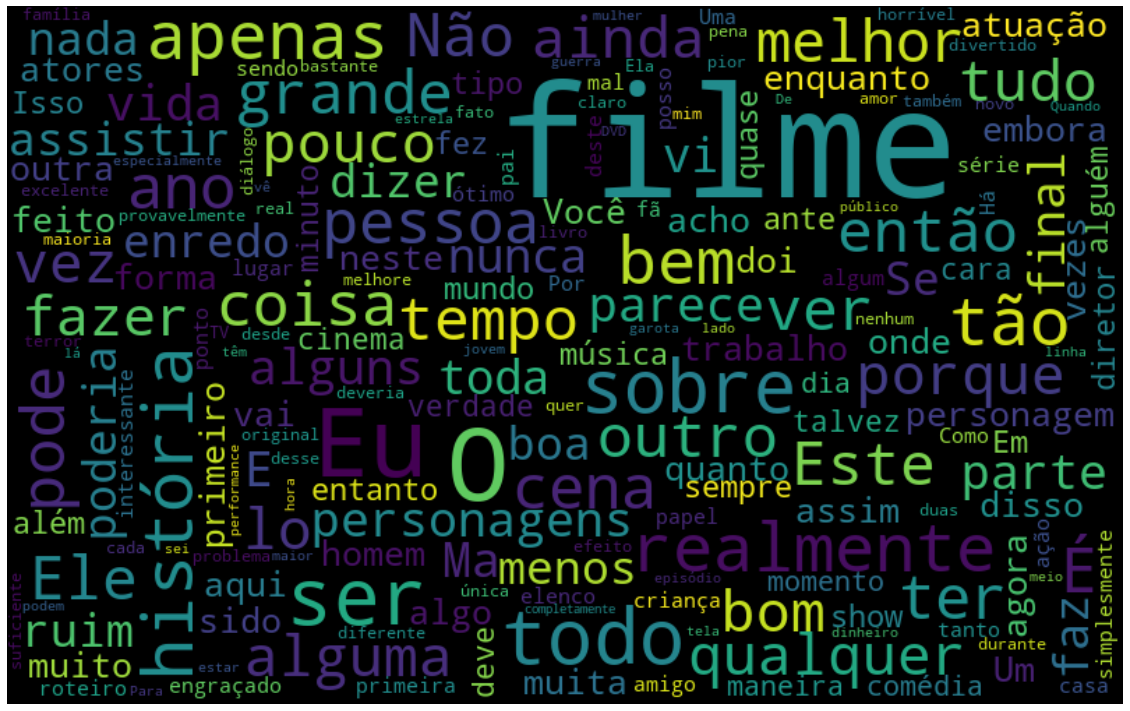

In [19]:
nuvem_palavras(df3, 'tratamento_2')

### Todas as palavras - Pós tratamento 3

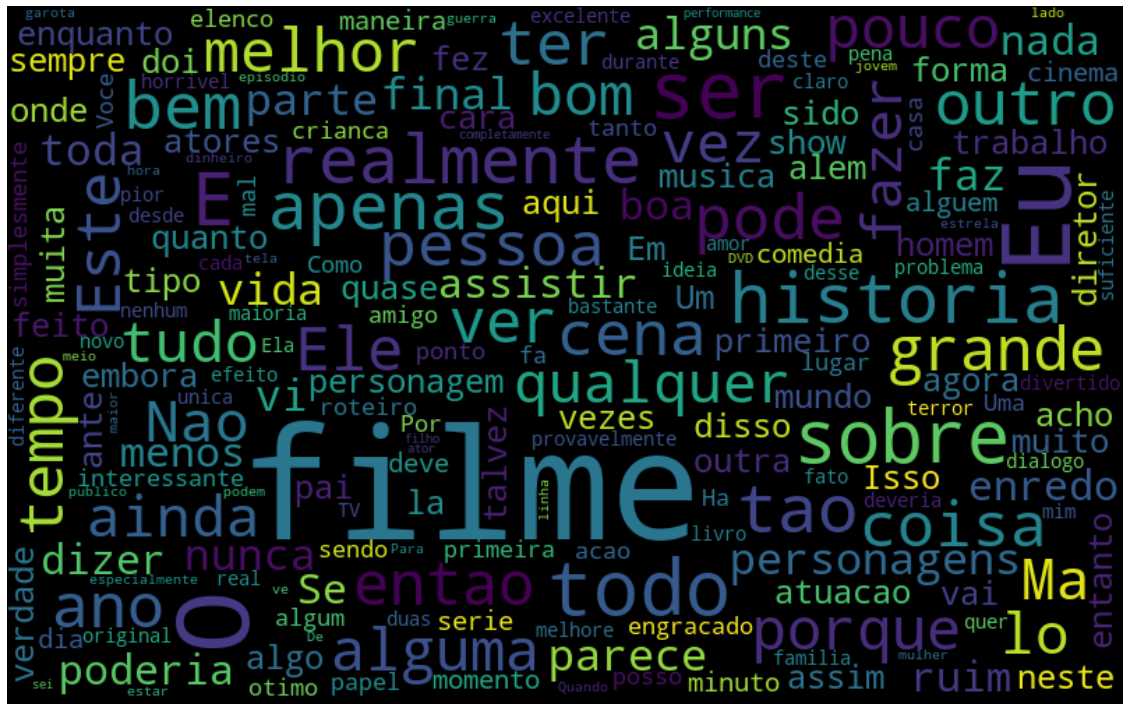

In [20]:
nuvem_palavras(df3, 'tratamento_3')

### Palavras postivas

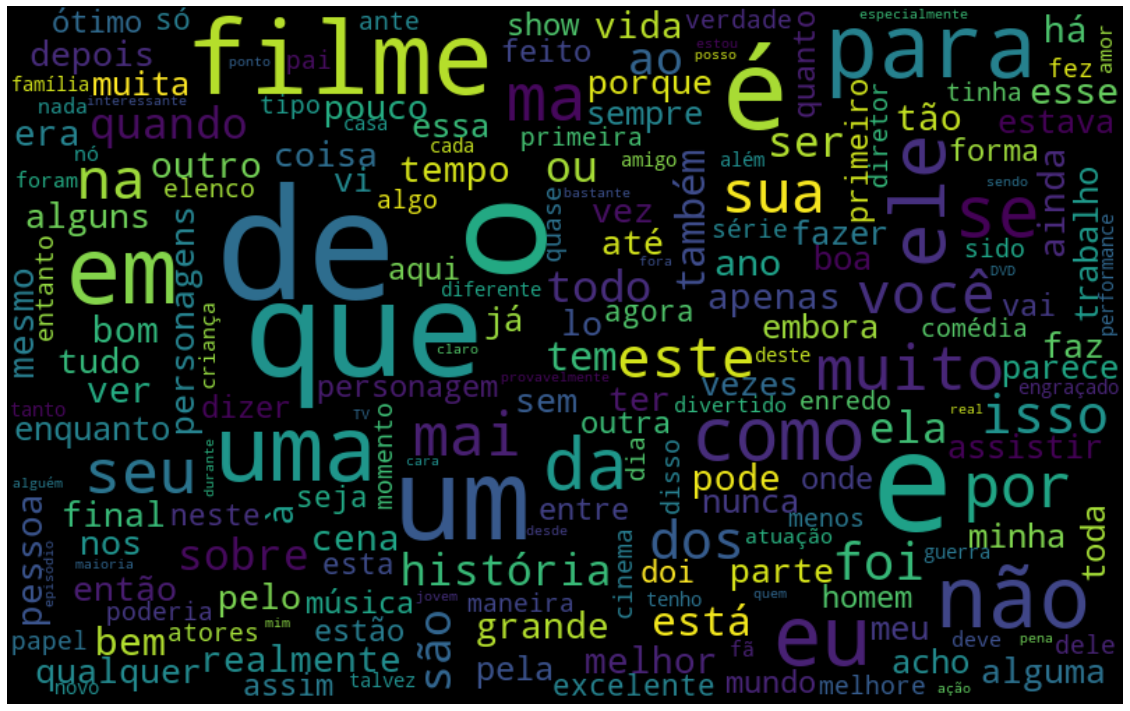

In [21]:
#palavras positivas
df_positivo = df3.loc[df3.classificacao == 1]
nuvem_palavras(df_positivo, 'text_pt')

### Palavras postivas - Pós tratamento 1

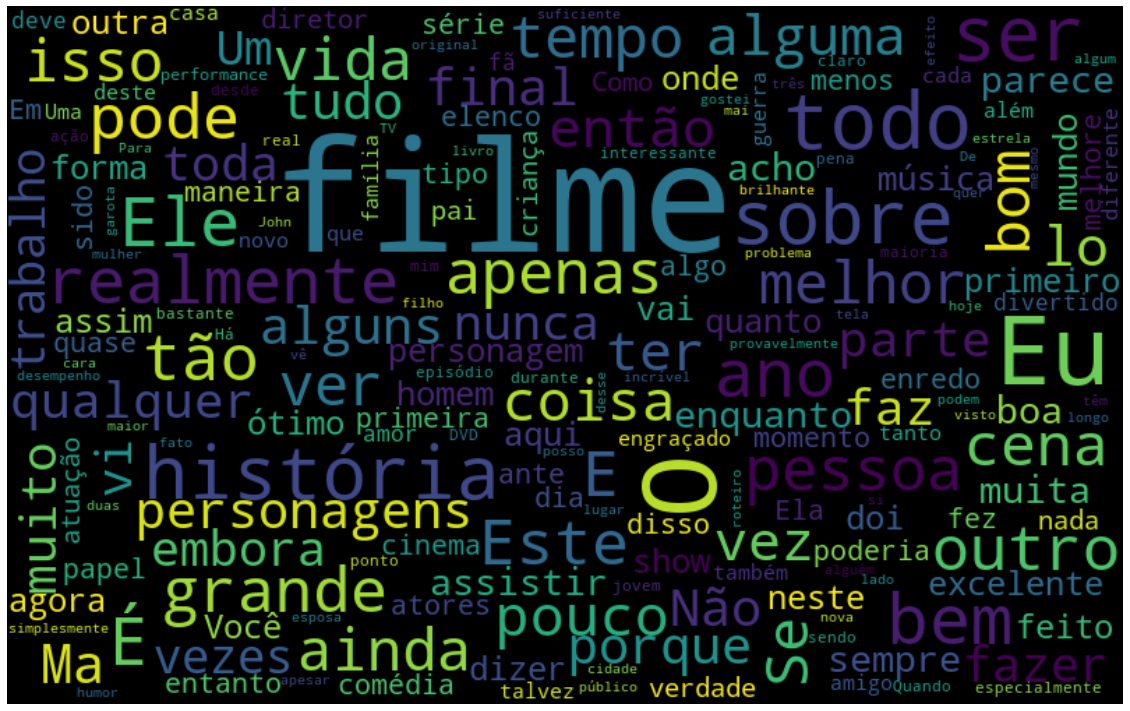

In [22]:
#palavras positivas
df_positivo = df3.loc[df3.classificacao == 1]
nuvem_palavras(df_positivo, 'tratamento_1')

### Palavras postivas - Pós tratamento 2

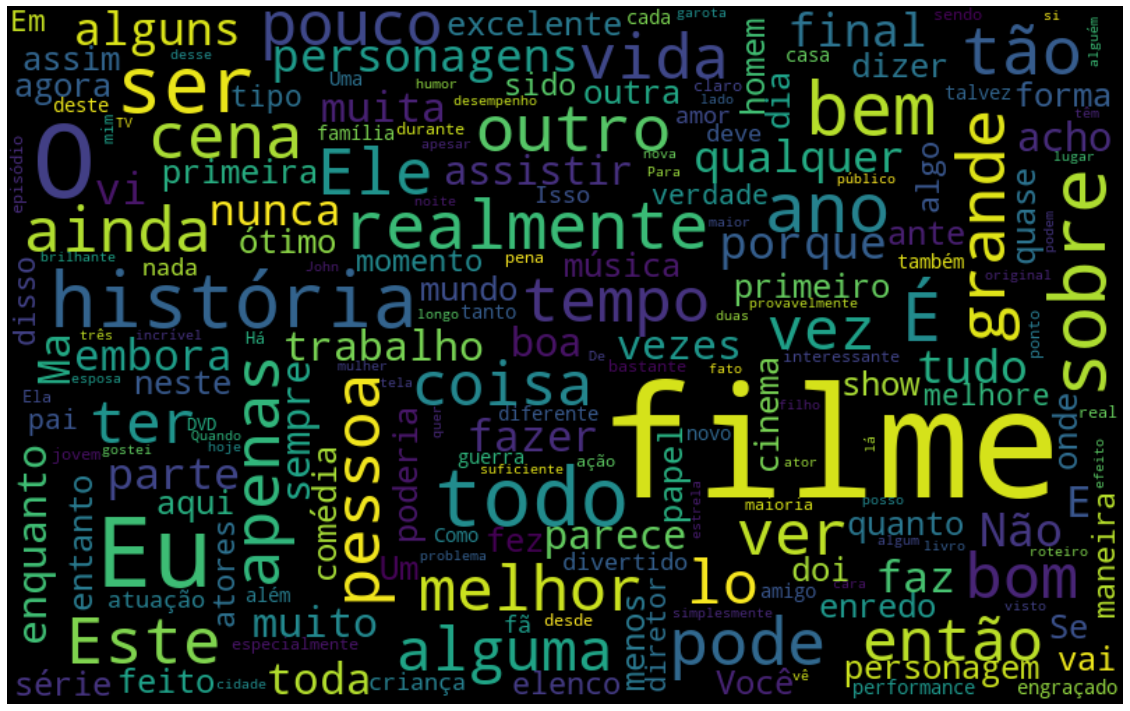

In [23]:
#palavras positivas
nuvem_palavras(df_positivo, 'tratamento_2')

### Palavras postivas - Pós tratamento 3

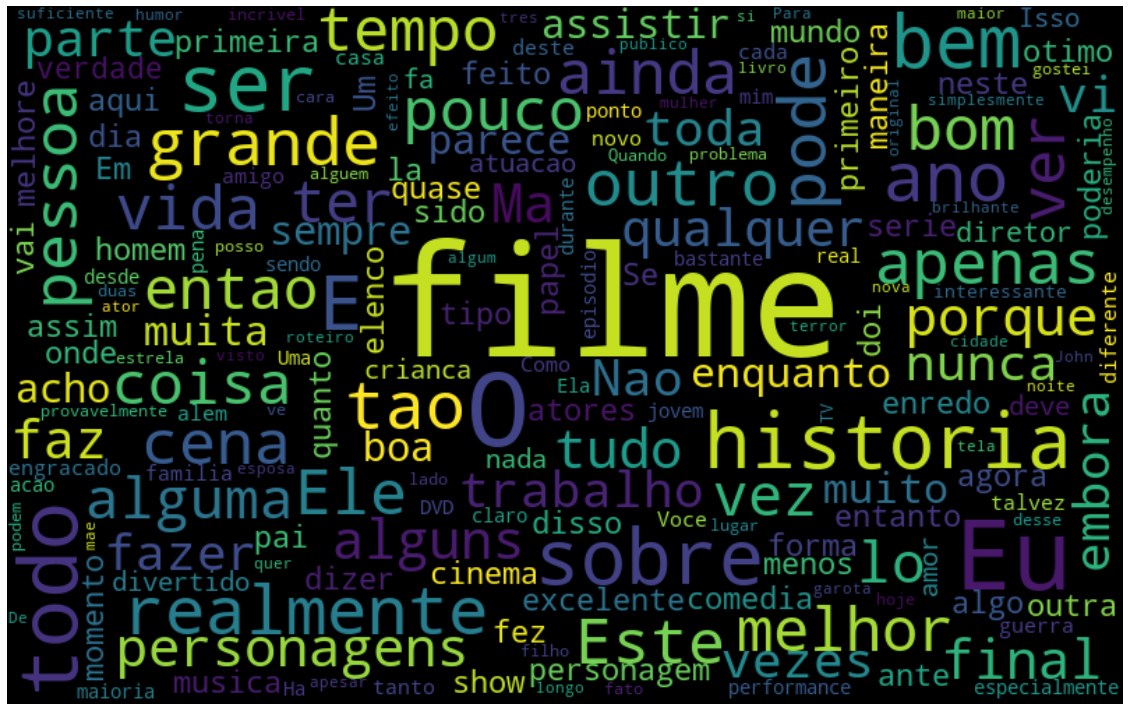

In [24]:
#palavras positivas
nuvem_palavras(df_positivo, 'tratamento_3')

### Palavras Negativas

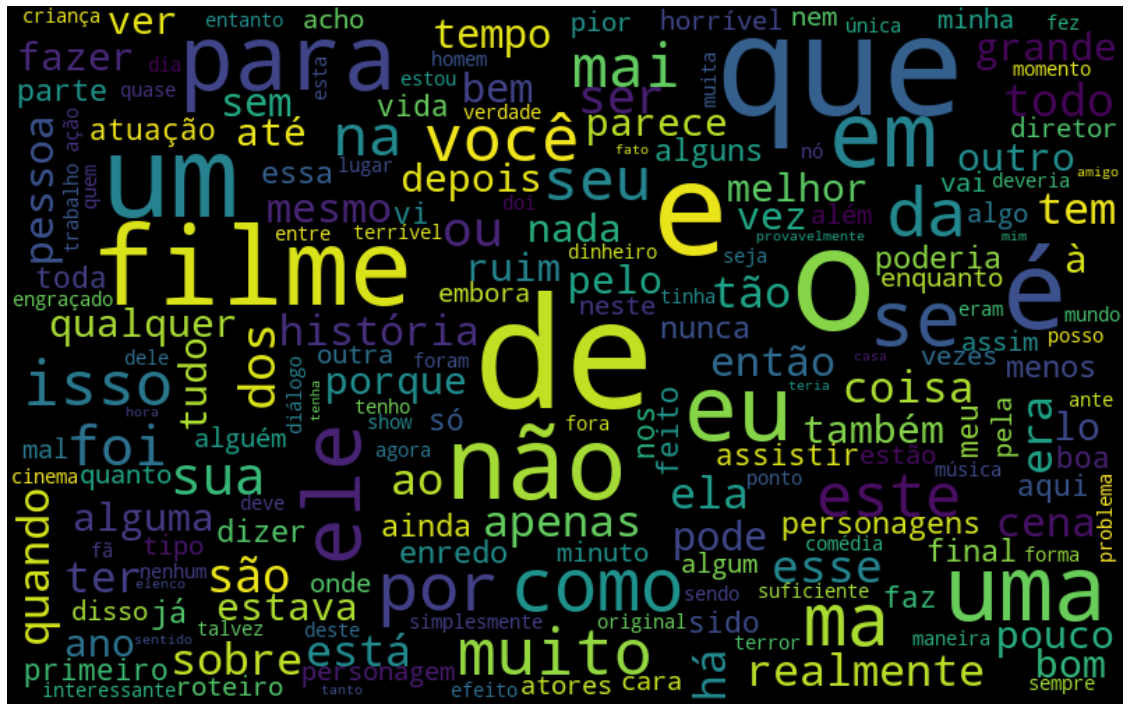

In [25]:
#palavras Negativas
df_negativo = df3.loc[df3.classificacao == 0]
nuvem_palavras(df_negativo, 'text_pt')

### Palavras Negativas -pós tratamento 1

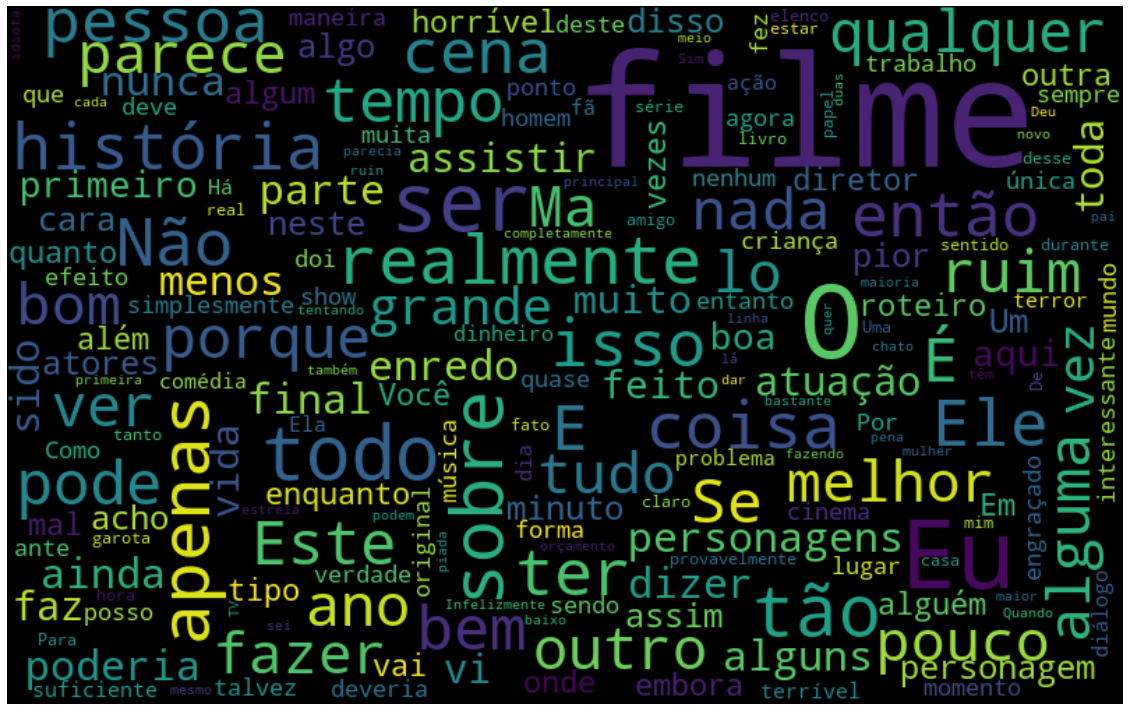

In [26]:
#palavras Negativas
df_negativo = df3.loc[df3.classificacao == 0]
nuvem_palavras(df_negativo, 'tratamento_1')

### Palavras Negativas -pós tratamento 2

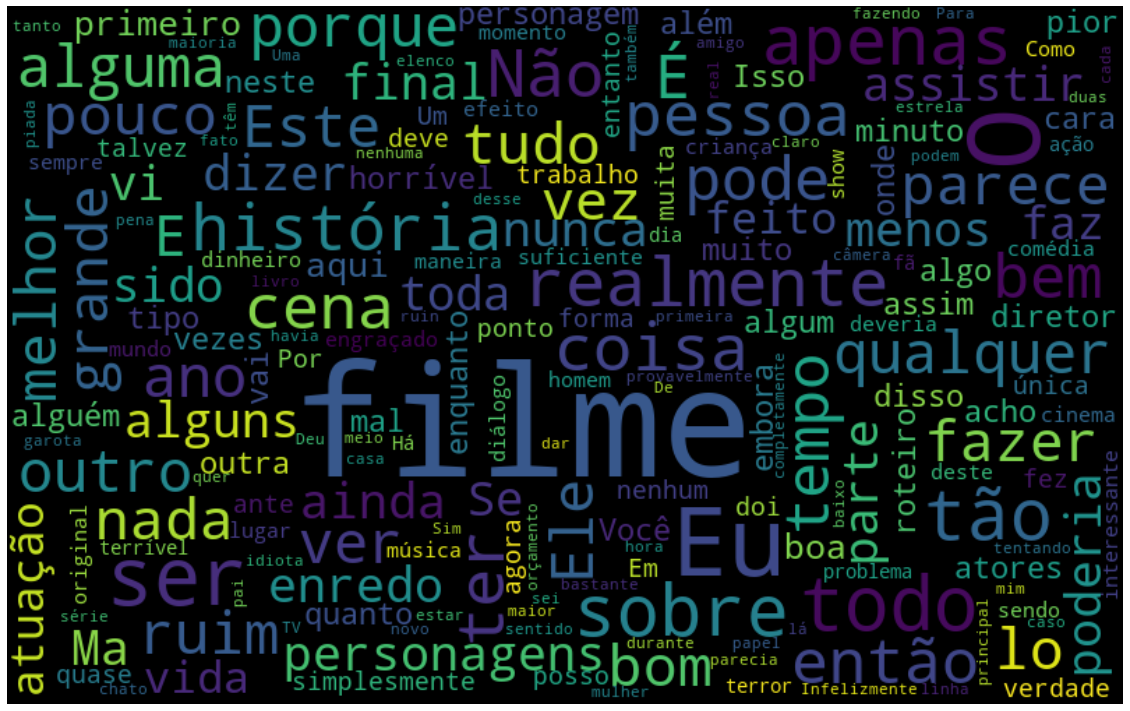

In [27]:
nuvem_palavras(df_negativo, 'tratamento_2')

### Palavras Negativas -pós tratamento 3

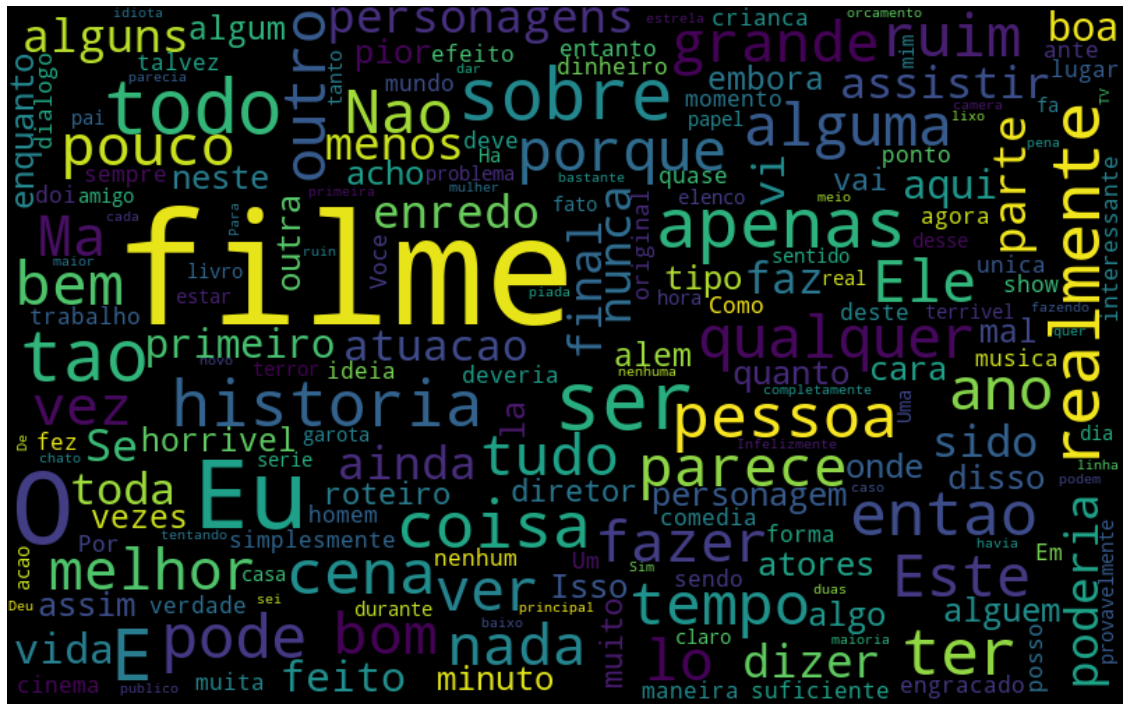

In [28]:
nuvem_palavras(df_negativo, 'tratamento_3')

## 3.4 NLTK

### Usando texto completo

In [29]:
#Tokenizano e achando a frequencia das palavaras no dataframe
todas_palavras = ' '.join([texto for texto in df3['text_pt']])
token_frase  = token_espaco.tokenize( todas_palavras )
frequencia = nltk.FreqDist(token_frase )
frequencia 

FreqDist({'de': 417651, 'que': 325070, 'e': 299743, 'o': 244881, 'um': 216410, 'a': 210179, 'é': 192381, 'em': 132778, 'uma': 130888, 'não': 127915, ...})

In [30]:
#DataFrame de frequencias de palavras
df_frequencia = pd.DataFrame({'Palavra': list(frequencia.keys()),
                             'Frequencia': list(frequencia.values())})

df_frequencia.sort_values('Frequencia', ascending = False ).head(10)

Palavra  Frequencia
20       de      417651
14      que      325070
42        e      299743
3         o      244881
7        um      216410
102       a      210179
45        é      192381
200      em      132778
1       uma      130888
29      não      127915

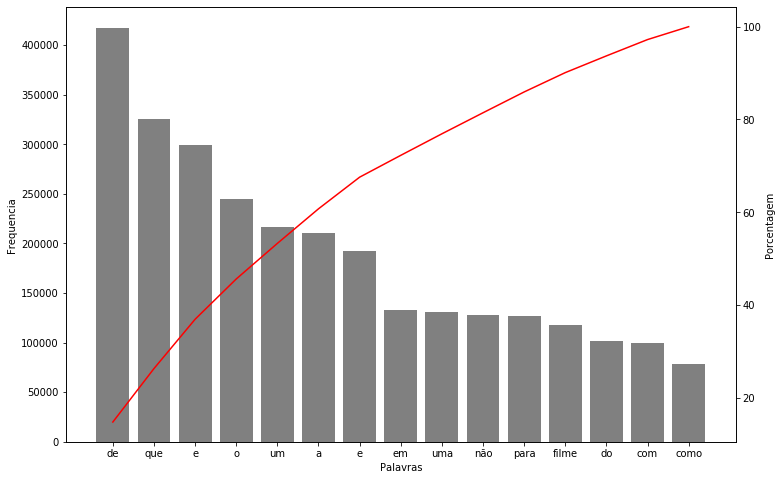

In [31]:
#Grafico de frequencia das palavras
pareto(df3, 'text_pt', 15)

### Após tratamento 1

In [32]:
#Tokenizano e achando a frequencia das palavaras no dataframe
todas_palavras = ' '.join([texto for texto in df3['tratamento_1']])
token_frase  = token_espaco.tokenize( todas_palavras )
frequencia = nltk.FreqDist(token_frase )

#DataFrame de frequencias de palavras
df_frequencia = pd.DataFrame({'Palavra': list(frequencia.keys()),
                             'Frequencia': list(frequencia.values())})

df_frequencia.sort_values('Frequencia', ascending = False ).head(10)

Palavra  Frequencia
5        filme      117543
245         Eu       51485
31           O       44924
70         ser       32696
19           A       31547
196          -       28767
64       sobre       28626
85      filmes       27619
241        tão       24790
177  realmente       23673

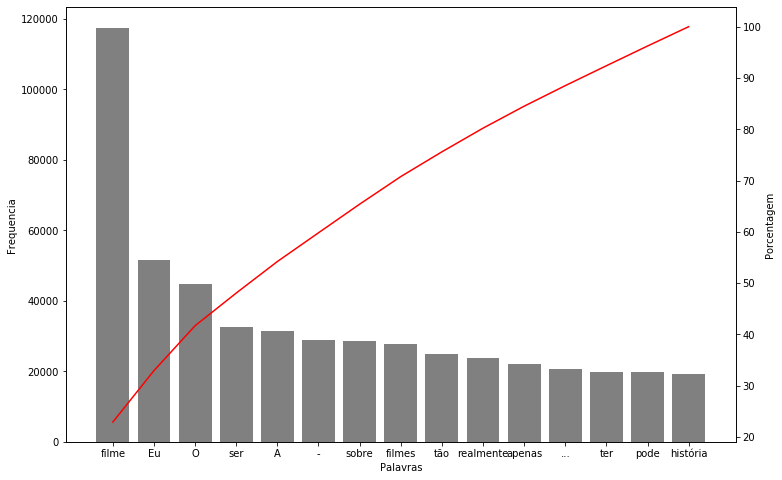

In [33]:
#Grafico de frequencia das palavras
pareto(df3, 'tratamento_1', 15)

### Após tratamento 2

In [34]:
#Tokenizano e achando a frequencia das palavaras no dataframe
todas_palavras = ' '.join([texto for texto in df3['tratamento_2']])
token_frase  = token_espaco.tokenize( todas_palavras )
frequencia = nltk.FreqDist(token_frase )

#DataFrame de frequencias de palavras
df_frequencia = pd.DataFrame({'Palavra': list(frequencia.keys()),
                             'Frequencia': list(frequencia.values())})

df_frequencia.sort_values('Frequencia', ascending = False ).head(10)

Palavra  Frequencia
5        filme      152842
233         Eu       53719
31           O       47326
67         ser       34046
19           A       33663
82      filmes       32150
62       sobre       28875
229        tão       24939
167  realmente       24146
469   história       23599

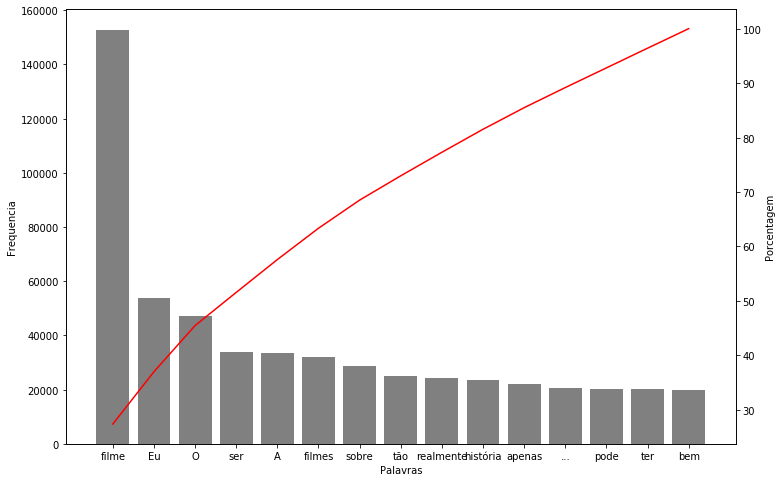

In [35]:
#Grafico de frequencia das palavras
pareto(df3, 'tratamento_2', 15)

### Após tratamento 3

In [36]:
#Tokenizano e achando a frequencia das palavaras no dataframe
todas_palavras = ' '.join([texto for texto in df3['tratamento_3']])
token_frase  = token_espaco.tokenize( todas_palavras )
frequencia = nltk.FreqDist(token_frase )

#DataFrame de frequencias de palavras
df_frequencia = pd.DataFrame({'Palavra': list(frequencia.keys()),
                             'Frequencia': list(frequencia.values())})

df_frequencia.sort_values('Frequencia', ascending = False ).head(10)

Palavra  Frequencia
5        filme      152842
232         Eu       53719
31           O       47334
19           A       34059
67         ser       34046
82      filmes       32150
139          E       30197
62       sobre       28875
228        tao       24939
166  realmente       24146

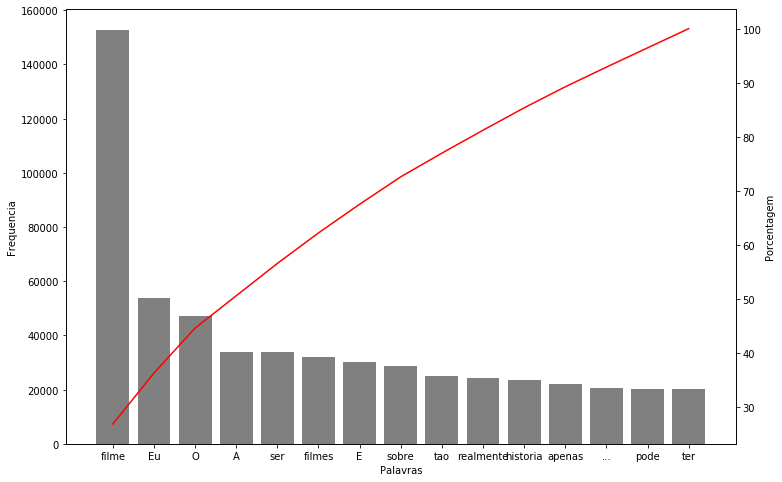

In [37]:
#Grafico de frequencia das palavras
pareto(df3, 'tratamento_3', 15)

# 4.0 Data Preparation

In [38]:
df4 = df3.copy()

# 5.0 Machine Learning

## 5.1 LogisticRegression - Bag of Words 

In [39]:
df5 = df4.copy()

>Usaremos o LogisticRegression como primeiro modelo para classificar os textos como boa avaliação ou ruim. 

> Para usarmos o LogisticRegression é necessário usar uma técnica de vetorização dos textos, foi usado o bag of words. 

### Resultados sem tratamento dos dados

In [40]:
acuracia = classificar_texto(df5, 'text_pt', 'classificacao', 50 )
print('Acuracia medida pelo score da regressao logistica é: ', acuracia)


Acuracia medida pelo score da regressao logistica é:  0.6583097452486858


> Neste primeiro ciclo, usando uma configuração de 200 para o tamanho da matriz do modelo de LogistcRegression, conseguimos obter uma acertividade de 75,43%

### Após tratamento 1 - usando StopWords

In [41]:
acuracia = classificar_texto(df5, 'tratamento_1', 'classificacao', 200 )
print('Acuracia medida pelo score da regressao logistica é: ', acuracia)

Acuracia medida pelo score da regressao logistica é:  0.7763040841083704


> Após primeiro tratamento usando o stopwords para remover palavras irrelevantes, o algortmo LogisticRegression, conseguimos obter uma acertividade de 77,63%

> Um aumento de 3,2% na acurácia

### Após tratamento 2 - Retirando pontuação

In [42]:
acuracia = classificar_texto(df5, 'tratamento_2', 'classificacao', 200 )
print('Acuracia medida pelo score da regressao logistica é: ', acuracia)

Acuracia medida pelo score da regressao logistica é:  0.7746866154468257


> Após segundo tratamento usando retirando a pontuação para remover palavras irrelevantes, o algortmo LogisticRegression, conseguimos obter uma acertividade de 77,46%

> A acurácia neste caso ficou um pouco a baixo, 0,17%, o que mostra que teve pouco impácto no nosso modelo este tratamento. 

### Após tratamento 3 - Retirando acentuação

In [43]:
acuracia = classificar_texto(df5, 'tratamento_3', 'classificacao', 200 )
print('Acuracia medida pelo score da regressao logistica é: ', acuracia)



Acuracia medida pelo score da regressao logistica é:  0.7768701981399111


> Após segundo tratamento usando retirando a acentuação , o algortmo LogisticRegression, conseguimos obter uma acertividade de 77,68%

> A acurácia neste caso ficou um pouco a acima, 0,05%, comparando com antes do tratamento, mas com melhora quase que irrelevante.  